Main goal of this notebook is to use the google earth engine to identify and create features that represent the shoreline/waterline of the wetland projects based on different parameters like NDWI, VV and VH backscatter, and individual mutispectral bands

In [ ]:
## before anything you need to visit the site below and make sure you have a google earth engine account
## this is so you can access Sentinel-1 GRD and Sentinel-2 TOA and SR products, as well as other sensor packages and data types

## visit the below website below to setup an earth engine account, enable a cloud project, and enable the ee API 
## https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup#get-access-to-earth-engine

In [196]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
## only need to run this once
## after authenticating with google earth engine you will only need to initialize each session

## https://developers.google.com/earth-engine/guides/auth
ee.Authenticate()

In [197]:
## init ee cloud project you made during initial setup
ee.Initialize(project = '') ##enter your project name here as a string to initialize exchanges with ee api

# Some functions for a bit easier mapping
super simple for now, might make them better later

In [198]:
## Function to add RGB images to the map.
def add_rgb_to_map(image, map_object, coll):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo(): ## all images if small enough image collection
        map_object.addLayer(image, {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'{date}_rgb')

## Function to add spectral indices images to the map.
def add_ind_to_map(image, map_object, coll):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo():
        if band =='NDWI':
            map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': ['00FFFF', '0000FF']}, f'{date}_{band}')
        elif band =='NDVI': 
            map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': ['FF0000', '008000']}, f'{date}_{band}')

## Function to add spectral indices images to the map.
def add_sar_to_map(image, map_object, coll, target_band):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo():
        if band == target_band:
            map_object.addLayer(image, {'min': -50, 'max': 1, 'bands': band}, f'{date}_{band}')

In [199]:
## functiont to create three important and popular spectral indices
## ndvi = Normalized Difference Vegetation Index, good for vegetation health and cover
## ndwi = Normalized Difference Water Index, good for identifying water bodies and mositure in surface
def s2_10m_target_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands([ndvi, ndwi])

## collects sentinel-1 GRD (radar, no phase) and Sentinel-2 SR (multispectral, adjusted for top of atmosphere reflectance)
def get_sentinel_imagery(aoi, start_date, end_date, s2_cloud_cov, orbit):
    ## Sentinel-1 ImageCollection
    s1_VV = (ee.ImageCollection('COPERNICUS/S1_GRD')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.eq('orbitProperties_pass', orbit))
               .select(['VV'])
               .sort('date')
    )

    s1_VH = (ee.ImageCollection('COPERNICUS/S1_GRD')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.eq('orbitProperties_pass', orbit))
               .select(['VH'])
               .sort('date')
    )

    ## Clip all images in the collection to the AOI
    s1_VV = s1_VV.map(lambda img: img.clip(aoi))
    s1_VH = s1_VH.map(lambda img:img.clip(aoi))
    ## Sentinel-2 Surface Reflectance Harmonized ImageCollection
    s2_10m = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', s2_cloud_cov))
               .sort('date')
               .select(['B2', 'B3', 'B4', 'B8'])
    )
    ## Clip all images in the collection to the AOI
    s2_10m = s2_10m.map(lambda img: img.clip(aoi))
    ## Apply indices to the Sentinel-2 images
    s2_10m_ndvi = s2_10m.map(s2_10m_target_indices).select(['NDVI'])
    s2_10m_ndwi = s2_10m.map(s2_10m_target_indices).select(['NDWI'])
    
    return s1_VV, s1_VH, s2_10m, s2_10m_ndvi, s2_10m_ndwi


In [200]:
## fucntion to get the date of each image in the image collection
def get_date(image):
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})

In [201]:
def export_image_to_drive(collection, collname, image, index):
    # Define the description for the export, incorporating the index for uniqueness

    if collname == 's1_VV':
        description = f"s1_VV_{index}"
    elif collname == 's1_VH':
        description = f's1_VH_{index}'
    elif collname == 'rgb':
        description = f's2_10m_{index}'
    elif collname == 'ndvi':
        description = f's2_10m_ndvi_{index}'
    else:
        description = f's2_10m_ndwi_{index}'

    # Setup the export task
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        region=aoi,  # Make sure the geometry is defined earlier
        fileFormat='GeoTIFF',
        scale = 10
    )
    task.start()
    print(f'Exporting {description} to Drive...')

def export_all_images(collection, collname):
    image_list = collection.toList(collection.size())  # Convert ImageCollection to List
    num_images = image_list.size().getInfo()  # Get the number of images

    if collname[:2] == 's1':
        for i, date in enumerate(s1_date_list):
            image = ee.Image(image_list.get(i))
            export_image_to_drive(collection, collname, image, date[:10])

    else:
        for i, date in enumerate(s2_date_list):
            image = ee.Image(image_list.get(i))
            export_image_to_drive(collection, collname, image, date[:10])

In [203]:
# Define a function to get histogram of NDWI for each image
def get_histogram(image, scale, bucket_num, band_name):
    """
    Used to create ndwi histograms for the imagery

    image = ee.Image
        NDWI image to determine the shoreline from
    scale = int
        scale to estimate the histogram from, typically 10 to match the resolution of the RGB imagery
    bucket_num = int
        number of buckets to put the data into for histogram
    band_name = str
        the name of your target band in the image
    """


    # Reduce the image to get a histogram over the region of interest (ROI)
    hist = image.reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=bucket_num),  # Adjust the number of buckets as needed
        geometry=aoi,
        scale=scale,  # Adjust based on image resolution
        maxPixels=1e8
    )
    
    # Get the histogram data for NDWI
    histogram = ee.Dictionary(hist.get(band_name)).getInfo() 
    
    return histogram

In [204]:
def otsu_trimodal_from_histogram(histogram):
    # Extract histogram and means from the provided NDWI histogram
    counts = np.array(histogram['histogram'])
    means = np.array(histogram['bucketMeans'])
    total = np.sum(counts)
    sum_values = np.sum(means * counts)
    overall_mean = sum_values / total
    size = len(means)

    # Define a function to compute the between-class variance (BSS)
    def compute_intervariance(i, k):
        # Compute for first region (A)
        aCounts = counts[:i]
        aCount = np.sum(aCounts)
        aMeans = means[:i]
        aMean = np.sum(aMeans * aCounts) / aCount if aCount != 0 else 0

        # Compute for second region (B)
        bCounts = counts[i:k]
        bCount = np.sum(bCounts)
        bMeans = means[i:k]
        bMean = np.sum(bMeans * bCounts) / bCount if bCount != 0 else 0

        # Compute for third region (C)
        cCounts = counts[k:]
        cCount = np.sum(cCounts)
        cMeans = means[k:]
        cMean = np.sum(cMeans * cCounts) / cCount if cCount != 0 else 0

        # Return combined BSS
        return aCount * (aMean - overall_mean) ** 2 + \
               bCount * (bMean - overall_mean) ** 2 + \
               cCount * (cMean - overall_mean) ** 2

    # Initialize an empty list for BSS values
    bss_values = []
    
    # Iterate through potential thresholds
    for i in range(1, size - 1):  # Start at 1, and stop before the last element
        for k in range(i + 1, size):  # Ensure k is always greater than i
            bss_values.append(compute_intervariance(i, k))

    # Convert BSS values to a NumPy array
    bss_array = np.array(bss_values)

    # Find indices of maximum BSS
    max_bss_index = np.argmax(bss_array)
    
    # Convert the flat index back to i and k values
    i_max = max_bss_index // (size - 1)
    k_max = max_bss_index % (size - 1)

    # Return corresponding means for the threshold
    return means[i_max], means[k_max]

# Get area of interest

In [205]:
## interactive map for you to draw a polygon to signify your aoi

## Create a map centered at a specific location
m = geemap.Map(center=[20, 0], zoom=2, basemap='HYBRID')
## Add drawing tools
m.add_draw_control()
## Display the map
display(m)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [240]:
## Get the drawn features
draw_features = m.draw_features[0]
## Establish ee.Polygon from drawn area of interest to collect imagery
aoi = ee.Geometry.Polygon(draw_features.getInfo()['geometry']['coordinates'][0])

# Get Imagery

In [241]:
start_date = '2019-09-01' ## start date of search window
end_date = '2024-09-01' ## end date of search window
s2_cloud_cov = 10 ## percentage of clouds in sentinel-2 multispectral imagery, less means you see more surface
orbit = 'ASCENDING' ## orbit for imagery

collections = {}
for i in range(int(start_date[:4]), int(end_date[:4])):
    collections[f's1_VV_{i}_{i+1}'], collections[f's1_VH_{i}_{i+1}'], collections[f's2_10m_{i}_{i+1}'], collections[f's2_10m_ndvi_{i}_{i+1}'], collections[f's2_10m_ndwi_{i}_{i+1}'] = get_sentinel_imagery(aoi, f'{i}{start_date[4:]}', f'{i+1}{end_date[4:]}', s2_cloud_cov, orbit)

In [208]:
colls = []
for i, coll in enumerate(collections):
    if collections[coll].size().getInfo() != 0: # removes image collections that are empty
        colls.append(coll)

for i, coll in enumerate(colls):
    print(f'{i}: {coll}')

# Visualize Distribution of NDWI Values for Select Images

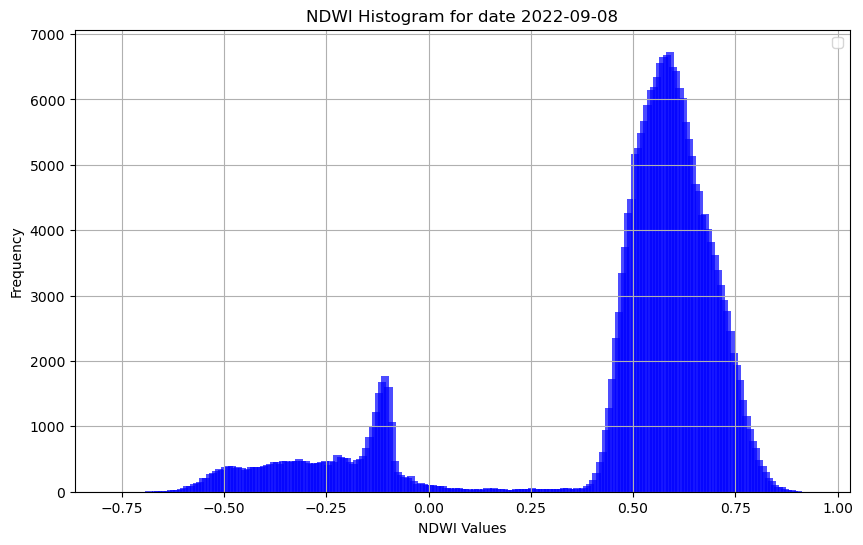

Thershold 1 = -0.10549094097113883
Thershold 2 = -0.5347365759568224


In [209]:
# no mask

# all I need for segmenting images into coastlines would be
# Need to make this applicable for each image in image collection
# it will read in a specified band of a passed image collection, then segment it using Otsu's method
# It should create a new image collection of 
#   1) Water Bodies, 2) Land Bodies, 3) Shorelines
# those can then be used to measure horizontal changes in shoreline over time

# Get the first image in the collection (or map over the collection if needed)
s2_date_list = collections[colls[19]].map(get_date).aggregate_array('date').getInfo()
ndwi_image = collections[colls[19]].first()

ndwi_date = s2_date_list[0]
ndwi_histogram = get_histogram(ndwi_image, 10, 150, 'NDWI')

# Extract the histogram values for plotting
ndwi_values = ndwi_histogram['bucketMeans']
ndwi_counts = ndwi_histogram['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndwi_values, ndwi_counts, width=0.02, color='blue', alpha=0.7)
plt.title(f"NDWI Histogram for date {ndwi_date}")
plt.xlabel("NDWI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(ndwi_histogram)
print(f'Thershold 1 = {edge_i}')
print(f'Thershold 2 = {edge_k}')

if edge_i < edge_k:
    ndwi_thresh = [edge_i, edge_k]
else:
    ndwi_thresh = [edge_k, edge_i]

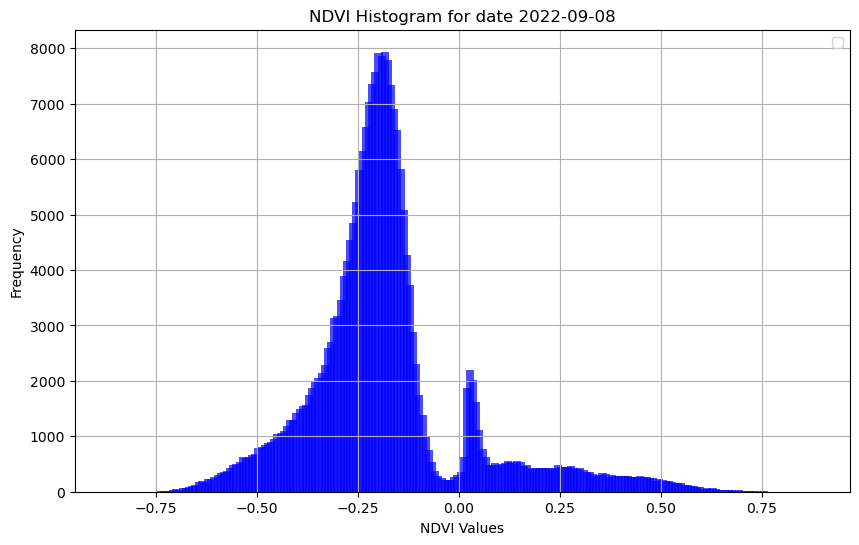

Thershold 1 = -0.4023237203659667
Thershold 2 = 0.7549738533705025


In [210]:
# no mask

# all I need for segmenting images into coastlines would be
# Need to make this applicable for each image in image collection
# it will read in a specified band of a passed image collection, then segment it using Otsu's method
# It should create a new image collection of 
#   1) Water Bodies, 2) Land Bodies, 3) Shorelines
# those can then be used to measure horizontal changes in shoreline over time

# Get the first image in the collection (or map over the collection if needed)
ndvi_image = collections[colls[18]].first()

ndvi_date = s2_date_list[0]
ndvi_histogram = get_histogram(ndvi_image, 10, 150, 'NDVI')

# Extract the histogram values for plotting
ndvi_values = ndvi_histogram['bucketMeans']
ndvi_counts = ndvi_histogram['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndvi_values, ndvi_counts, width=0.02, color='blue', alpha=0.7)
plt.title(f"NDVI Histogram for date {ndvi_date}")
plt.xlabel("NDVI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(ndvi_histogram)
print(f'Thershold 1 = {edge_i}')
print(f'Thershold 2 = {edge_k}')

if edge_i < edge_k:
    ndvi_thresh = [edge_i, edge_k]
else:
    ndvi_thresh = [edge_k, edge_i]

# Shoreline deteciton based on Otsu Trimodal Thresholds

In [238]:
water_mask = ndwi_image.lt(ee.Number(ndwi_thresh[0]))
land_mask = ndwi_image.gt(ee.Number(ndwi_thresh[1]))
water_land_mask = water_mask.Not().add(land_mask).divide(2)
shores = water_land_mask.updateMask(water_land_mask.gt(0.0))

# Create a binary mask for raster2 (for instance, non-zero values)
# binary_mask = ndwi_image.updateMask(ndwi_image.gte(0.0)).mask()
binary_mask = ndwi_image.updateMask(ndwi_image.gte(0.0)).mask()

# Dilate the mask
dilated_mask = binary_mask.focal_max(radius=1)

# Erode the mask
eroded_mask = binary_mask.focal_min(radius=1)

# Subtract the eroded mask from the dilated mask to get the border
border_mask = dilated_mask.subtract(eroded_mask)

border_pixels = shores.updateMask(border_mask) ###should be shoreline

In [231]:
# Define a gaussian kernel for smoothing
# gaussian_kernel = ee.Kernel.gaussian(radius=1)

# Apply gaussian smoothing to the shoreline mask
smoothed_shoreline = border_pixels.focal_max(radius=1, units='pixels', kernelType='gaussian').focal_min(radius=1, units='pixels', kernelType='gaussian')
shore_vectors = smoothed_shoreline.toInt().reduceToVectors(
    geometryType='polygon',    # Can also be 'line' for shoreline edges directly
    reducer=ee.Reducer.countEvery(),
    scale=10,                  # Adjust based on your raster resolution
    maxPixels=1e8
)

# Optionally, filter out small polygons
vectors = shore_vectors.filter(ee.Filter.gt('count', 100))  # Keep features with more than 100 pixels
shore_vectors

# Map RGB Imagery

In [239]:
rgb_image = collections[colls[17]].first()
# Display the shoreline as vector features
Map = geemap.Map()
Map.centerObject(aoi, 12)

# Add the original NDWI image for context
Map.addLayer(rgb_image, {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'Sentinel-2 RGB {ndwi_date}')
Map.addLayer(ndwi_image.updateMask(ndwi_image.gte(0.0)), {'min': 0, 'max': 1}, f'Water {ndwi_date}')

# Map.addLayer(rgb_image, {'min': 0, 'max': 2000, 'bands': ['B4']}, f'Sentinel-2 R {ndwi_date}')
# Map.addLayer(rgb_image, {'min': 0, 'max': 2000, 'bands': ['B3']}, f'Sentinel-2 G {ndwi_date}')
# Map.addLayer(rgb_image, {'min': 0, 'max': 2000, 'bands': ['B2']}, f'Sentinel-2 B {ndwi_date}')
# Map.addLayer(rgb_image, {'min': 0, 'max': 2000, 'bands': ['B8']}, f'Sentinel-2 NIR {ndwi_date}')

# Map.addLayer(shores, {'color': 'White'}, 'Shores')
Map.addLayer(border_pixels, {'color': 'White'}, 'Shoreline Borders')


# Display the map
Map.addLayerControl()
Map

Map(center=[26.3380141807707, -97.20405510883774], controls=(WidgetControl(options=['position', 'transparent_b…

# Export Shoreline information

In [ ]:
# Export the shoreline vector as GeoJSON for use in QGIS or GDAL
task = ee.batch.Export.table.toDrive(
    collection=vector_shoreline,
    description='Shoreline_Export',
    fileFormat='GeoJSON',  # GeoJSON is well-supported in QGIS and GDAL
    fileNamePrefix='shoreline'
)

# Start the export task
task.start()
print("Shoreline extraction task started, check Google Earth Engine tasks for progress.")

In [ ]:
Export.image.toDrive({
    'image': first_edge_image,
    'description': 'Canny_Edges_Example',
    'scale': 10,  # Adjust the scale according to the dataset resolution
    'region': aoi,
    'maxPixels': 1e8
})